### Extra Credit

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

validset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
validloader = torch.utils.data.DataLoader(validset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(device)  
# If 'mps or cuda:0' is printed, it means GPU is available.

Files already downloaded and verified
Files already downloaded and verified
mps


In [2]:
class ShortConn2d(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size=1, stride=stride, padding=0)
            
        self.bn = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

In [3]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 
                             kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # skip connect projection from in_channels to out_channels
        # depending on the stride and channels to do a projection
        # or just pass on the input
        if stride == 1 and in_channels == out_channels:
            self.shortcut = nn.Identity()
        else:
            self.shortcut = ShortConn2d(in_channels, out_channels, stride)
        
    def forward(self, x):
        # reserve this now for the skip connection
        shortcut = self.shortcut(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.bn2(x)

        # not applying activation here for densenet implementation
        return x + shortcut

In [37]:
class DenseMax(nn.Module):
    def __init__(self):
        super(DenseMax, self).__init__()
        
         ### RES 1
         
        # 3x32x32 to 10x32x32
        self.rb1 = ResBlock(3, 10, 1)
        self.act1 = nn.ReLU()
        # 10x32x32 to 10x16x16
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        ### RES 2
        
        # 10x16x16 to 20x16x16
        self.rb2 = ResBlock(10, 20, 1)
        # 3x32x32 to 20x16x16 skip connection
        self.res1_sc1 = ShortConn2d(3, 20, 2)
        self.act2 = nn.ReLU()
        # 20x16x16 to 20x8x8
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
                
        # 20x8x8 to 20x8x8
        self.rb3 = ResBlock(20, 20, 1)
        # 3x32x32 to 20x8x8 skip connection
        self.res1_sc2 = ShortConn2d(3, 20, 4)
        # 10x16x16 to 20x8x8 skip connection
        self.res2_sc1 = ShortConn2d(10, 20, 2)
        self.act3 = nn.ReLU()
        # 20x8x8 to 20x4x4
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # 20x4x4 affine operation to hidden layer with 100 neurons
        self.fc1 = nn.Linear(20 * 4 * 4, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.act4 = nn.ReLU()
        
        # affine operation to output layer with 10 neurons
        self.fc2 = nn.Linear(100, 10)
        
    def forward(self, x):
       
        res1_sc1 = self.res1_sc1(x)
        res1_sc2 = self.res1_sc2(x)
        
        x = self.rb1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        res2_sc1 = self.res2_sc1(x)

        x = self.rb2(x)
        x = self.act2(x + res1_sc1)
        x = self.pool2(x)
        
        x = self.rb3(x)
        x = self.act3(x + res1_sc2 + res2_sc1)
        x = self.pool3(x)
                
        # flatten and pass through fully connected layers
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act4(x)
        x = self.fc2(x)
        return x


In [15]:
PATH = './models/cifar_dense_max_adam.pth'

epochs = 10             # Total epochs.
iter_n = len(trainloader)  # number of iteration per epoch
record_freq = iter_n // 100  # Record frequency.
print_freq = iter_n // 100 # Print frequency, need to be multiple of record_freq.

# a number for computing running validation loss in each iteration.
train_per_valid = len(trainloader) / len(validloader)  

avg_train_losses, avg_valid_losses = [], []   # Avg. losses.
train_accuracies, valid_accuracies = [], []  # Train and test accuracies.

dense_max = DenseMax()     # Create the network instance.
dense_max.to(device)  # Move the network parameters to the specified device.

# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  

# We use Adam as optimizer.
opt = optim.Adam(dense_max.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)

# add scheduling
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.7)

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_train_loss = 0.0       # Initialize running train_loss for training set.
    running_val_loss = 0.0     # Initialize running train_loss for validation set.
    
    # Initialize running total and correct for computing train accuracy.
    train_correct = 0 
    train_total = 0
    # Initialize running total and correct for computing test accuracy.
    valid_total = 0   
    valid_correct = 0
    
        
    print('--> [Start of epoch {}]'.format(epoch) +
          '  lr: {:.6f}'.format(scheduler.get_last_lr()[0]))
    
    validiter = iter(validloader)
    for i, data in enumerate(iterable=trainloader, start=0):
        
        # Set the model to training mode.
        dense_max.train()
        
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step
        train_output = dense_max(inputs)
        train_loss = loss_func(train_output, labels)
        
        # Backward step.
        train_loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()
        
        dense_max.eval()
        
        # record statistics.
        running_train_loss += train_loss.item()
        
        # this is for recording training accuracy
        _, train_predicted = torch.max(train_output.data, 1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels).sum().item()
        
        # only iterate through validation set according to train_per_valid ratio
        if i % train_per_valid == train_per_valid - 1:
            # Set the model to evaluation mode.
            with torch.no_grad():
                valid_inputs, valid_labels = next(validiter)
                valid_inputs, valid_labels = valid_inputs.to(device), valid_labels.to(device)
                valid_output = dense_max(valid_inputs)
                valid_loss = loss_func(valid_output, valid_labels)
                running_val_loss += valid_loss.item()
                
                _, valid_predicted = torch.max(valid_output.data, 1)
                valid_total += valid_labels.size(0)
                valid_correct += (valid_predicted == valid_labels).sum().item()
            
        # Record training/validation loss every several mini-batches.
        if i % record_freq == record_freq - 1: 
            avg_train_loss = running_train_loss / record_freq
            avg_train_losses.append(avg_train_loss)
            avg_valid_loss = train_per_valid * running_val_loss / record_freq
            avg_valid_losses.append(avg_valid_loss)
            running_train_loss, running_val_loss = 0.0, 0.0
            
            # only print traing training loss once in a while to avoid cluster output
            if i % print_freq == print_freq - 1:
                print('[epoch: {}, i: {:5d}]'.format(epoch, i) +
                      '  train_loss: {:.3f}'.format(avg_train_loss) + 
                      '  |  valid_loss: {:.3f}'.format(avg_valid_loss))
                            

    # exponential scheduling
    scheduler.step()

                   
    # calculating train accuracy
    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    
    valid_accuracy = 100 * valid_correct / valid_total
    valid_accuracies.append(valid_accuracy)     
    
    # Store the networks after each epochs.
    # in case we want to do simple average or weighted average
    torch.save({
            'epoch': epoch,
            'model_state_dict': dense_max.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'train_loss': avg_train_losses[epoch],
            'train_accuracy': train_accuracies[epoch],
            'valid_accuracy': valid_accuracies[epoch],
            }, PATH)
    
    print('--> [End of epoch {}]'.format(epoch) +
                      ' train_accuracy: {:.2f}%'.format(train_accuracy) + 
                      '  |  valid_accuracy: {:.2f}%'.format(valid_accuracy))

print('Finished Training.')

--> [Start of epoch 0]  lr: 0.001000
[epoch: 0, i:   124]  train_loss: 2.157  |  valid_loss: 2.137
[epoch: 0, i:   249]  train_loss: 1.987  |  valid_loss: 1.916
[epoch: 0, i:   374]  train_loss: 1.929  |  valid_loss: 1.829
[epoch: 0, i:   499]  train_loss: 1.948  |  valid_loss: 1.696
[epoch: 0, i:   624]  train_loss: 1.887  |  valid_loss: 1.699
[epoch: 0, i:   749]  train_loss: 1.837  |  valid_loss: 1.655
[epoch: 0, i:   874]  train_loss: 1.808  |  valid_loss: 1.660
[epoch: 0, i:   999]  train_loss: 1.758  |  valid_loss: 1.583
[epoch: 0, i:  1124]  train_loss: 1.795  |  valid_loss: 1.552
[epoch: 0, i:  1249]  train_loss: 1.791  |  valid_loss: 1.469
[epoch: 0, i:  1374]  train_loss: 1.750  |  valid_loss: 1.525
[epoch: 0, i:  1499]  train_loss: 1.712  |  valid_loss: 1.520
[epoch: 0, i:  1624]  train_loss: 1.720  |  valid_loss: 1.585
[epoch: 0, i:  1749]  train_loss: 1.730  |  valid_loss: 1.549
[epoch: 0, i:  1874]  train_loss: 1.724  |  valid_loss: 1.365
[epoch: 0, i:  1999]  train_loss:

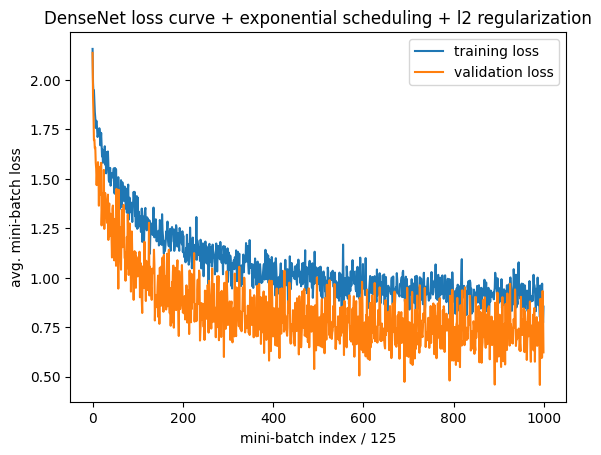

In [20]:
plt.plot(avg_train_losses)
plt.plot(avg_valid_losses)
plt.title('DenseNet loss curve + exponential scheduling + l2 regularization')
plt.xlabel('mini-batch index / {}'.format(record_freq))
plt.ylabel('avg. mini-batch loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

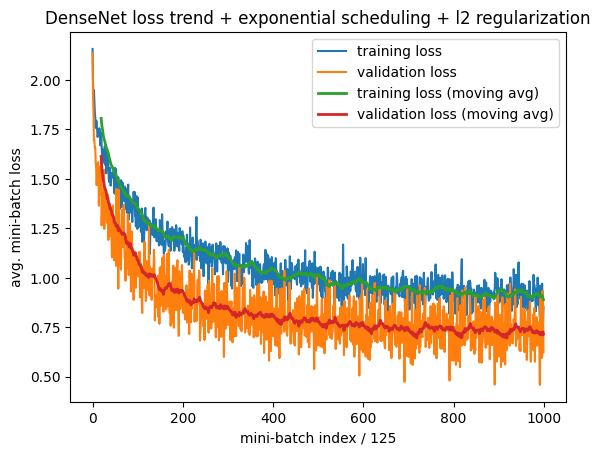

In [35]:
def moving_average(data, window_size):
    """Compute the moving average of the data using a specified window size."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 20  # Adjust this based on your preference
train_losses_ma = moving_average(avg_train_losses, window_size)
valid_losses_ma = moving_average(avg_valid_losses, window_size)

# x_axis = np.arange(len(train_losses_ma))/100 
x_axis = np.arange(window_size - 1, len(train_losses_ma) + window_size - 1)

plt.plot(avg_train_losses)
plt.plot(avg_valid_losses)
plt.plot(x_axis, train_losses_ma, linewidth=2)
plt.plot(x_axis, valid_losses_ma, linewidth=2)
plt.title('DenseNet loss trend + exponential scheduling + l2 regularization')
plt.xlabel('mini-batch index / {}'.format(record_freq))
plt.ylabel('avg. mini-batch loss')
plt.legend(['training loss', 'validation loss', 'training loss (moving avg)', 'validation loss (moving avg)'])
plt.show()

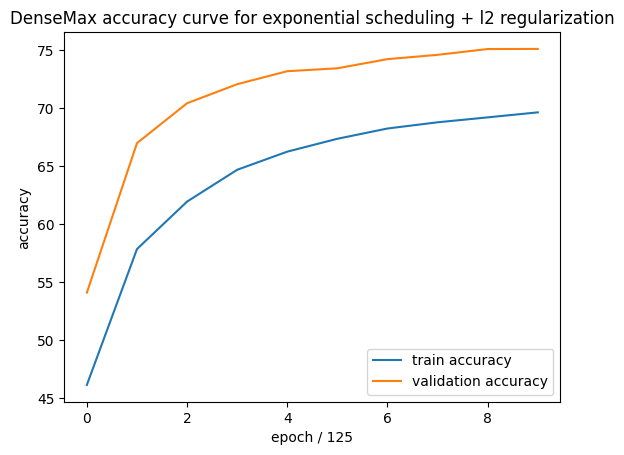

In [36]:
plt.plot(train_accuracies)
plt.plot(valid_accuracies)
plt.title('DenseMax accuracy curve for exponential scheduling + l2 regularization')
plt.xlabel('epoch / {}'.format(record_freq))
plt.ylabel('accuracy')
plt.legend(['train accuracy', 'validation accuracy'])
plt.show()

In [11]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

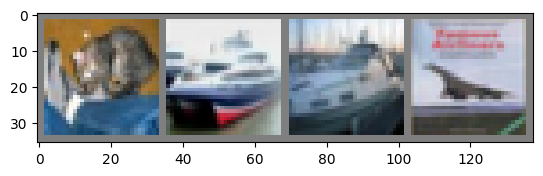

GroundTruth:    cat  ship  ship plane
Predicted:   frog   car  ship plane


In [12]:
# Check several images.
dataiter = iter(validloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = dense_max(images.to(device))

# max compare along the row, return the index of the max value, which is the predicted class
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [18]:
dense_max.to(device)

dense_max.eval()
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = dense_max(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 75.73 %


In [24]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = dense_max(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 78 %
Accuracy of   car : 86 %
Accuracy of  bird : 56 %
Accuracy of   cat : 57 %
Accuracy of  deer : 74 %
Accuracy of   dog : 66 %
Accuracy of  frog : 81 %
Accuracy of horse : 83 %
Accuracy of  ship : 87 %
Accuracy of truck : 86 %


#### Observation
Before doing any experiment, I gathered some information from the average pooling based model as described in Q5.

I first plot the training loss curve at a frequency of 100 times per epoch to understand the training process. Then I plot the accuracy comparison once per epoch (computing accuracy is expensive) to make more observations.

Judging from the training loss curve alone, the model converge nicely and the loss does not fluctuate too much toward the end of the training,

Observing the accuracy comparison chart from average pooling based model as described in Q5, we can see the gap between train accuracy and test accuracy start getting bigger in each epoch; more precisely, test accuracy does not increase in proportion to train accuracy. This is a clear sign of overfitting.

#### Experiment
To address overfitting, some form of regularization is needed, therefore I decided to try out various techniques such as Batch Normalization and Dropout. I've also tried switching from average pooling to max pooling because it's a more common practice than average pooling to extract features from the input.

I was then to achieve around 68-69 percent in different variations of the max pooling model with either dropout or l2 regularization.

The ones I've found giving the most consistent good result is just either max or average pooling approach with batch normalization after every Conv2D layer and linear layer before activation function.

#### Final Implementation (went crazy)
However, I then decided to restructure my model completely, I was able to achieve around 70 percent with very simple 2 residual blocks Resnet model + batch normalization + l2 regularization

Then I added one extra layer, and implement Densenet's idea, you can see in my code I not only have the standard skip connection, I also have the dense connection, which is the concatenation of all previous layers. This model initially achieved incredible 73.98% validation accuracies, but this process definitely took a lot of time to train just 10 epochs

Then I decided to add back max pooling in between residual blocks just right after concatenation with dense skip connection because from my understanding in limited resources, having max pooling can reduce some computation while allowing deeper network to be trained, which proven to be the case.

There, my final model is a Densenet with 3 residual blocks + 3 max pooling layers + 3 dense skip connections + all associated batch normalization layers + 2 fully connection layers, using Adam with default betas (0.9, 0.99) and weight decay of 1e-4 (which is the equivalence of l2 regularization in Pytorch implementation). This model achieved 75.73% accuracy from just 10 epochs.

#### Potential further improvement
The model still have problem with classifying cat, dog and bird, which I believe can be improved by adding more data augmentation on the training set just for those classes. I think it wouldn't be too much of a challenge to get my accuracy to 80% with cyclic learning rate scheduling + data augmentation, and then just use model esembling to get that couple more percents.

#### Some Interesting Notes 
In Resnet's paper, they don't use max pooling in their model, which I believe is not suitable in achieving the best result for the purpose of this experiment because I don't have the resource to train a very deep network. Resnet also doesn't use fully connected layer, instead they only have one global avg pooling layer that compute one mean per feature map and pass to a linear layer right into Softmax for classification.